# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [2]:
file_comments = "../../../../data/reddit/PoliticalDiscussion_comments.zst"
file_submissions = "../../../../data/reddit/PoliticalDiscussion_submissions.zst"

subreddit_here = "PoliticalDiscussion"


output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io
import zipfile

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [6]:
# write comments to parquet
#import_subreddit_to_parquet(file_comments, "../../../data/reddit/political_discussion_comments_parquet_new.zst", chunk_size=100_000, data_type="comments")

# write submissions to parquet
#import_subreddit_to_parquet(file_submissions, "../../../data/reddit/political_discussion_submissions_parquet_new.zst", chunk_size=100_000, data_type="submissions")


In [5]:
data_comments = pd.read_parquet("../../../../data/reddit/political_discussion_comments_parquet_new.zst", engine="pyarrow")
data_submissions = pd.read_parquet("../../../../data/reddit/political_discussion_submissions_parquet_new.zst", engine="pyarrow")


In [8]:
# import data
#data_comments = import_subreddit(file_comments)
#data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 188504


In [8]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)


Nr. of pulled comments & replies 6839338


In [9]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 1371225
Nr. of replies 1071170


### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [10]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions
# get nr of submissions, for which I do have comments --> 29.304


8.069921962358315


,submission_id,count
0,100071,3
1,1000qm2,2
2,1000tff,2
3,1001mh,7
4,1002far,2
...,...,...
169913,zzyt8,1
169914,zzyvr,7
169915,zzz2om,1
169916,zzzhv,2


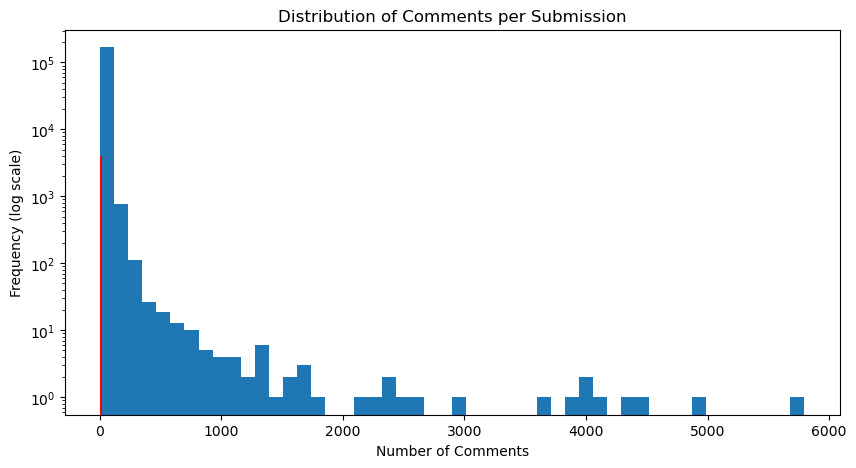

In [11]:
# Histogram
plt.figure(figsize=(10, 5))
plt.hist(relevant_submissions['count'], bins=50)
plt.vlines((relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4000)

plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Number of Comments")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Comments per Submission")
plt.show()


In [12]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,52312,0.000000,4.718601
1,2,51003,0.301030,4.707596
2,3,7701,0.477121,3.886547
3,4,5855,0.602060,3.767527
4,5,5323,0.698970,3.726156
...,...,...,...,...
389,4148,1,3.617839,0.000000
390,4359,1,3.639387,0.000000
391,4485,1,3.651762,0.000000
392,4943,1,3.693991,0.000000


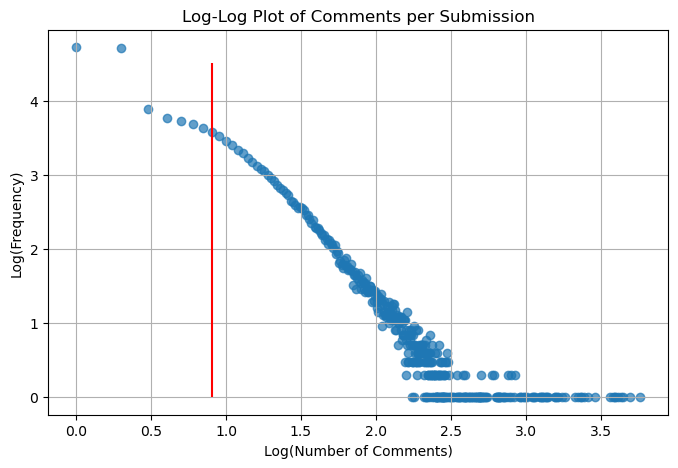

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Nr. of submissions')

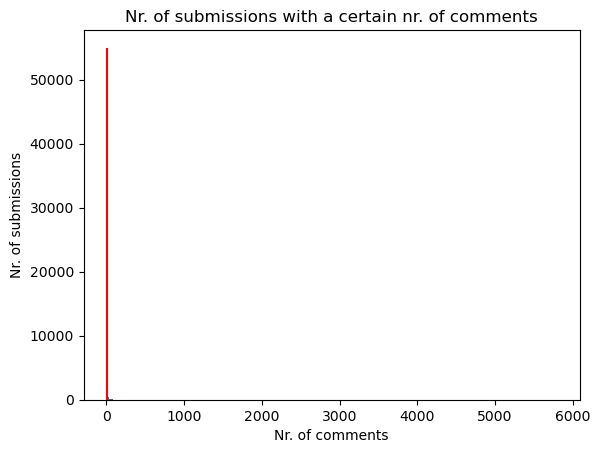

In [14]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['comment_count'], height = plt_data['class_count'])
plt.vlines(relevant_submissions['count'].mean(), colors="red", ymin = 0, ymax=55000)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

Text(0, 0.5, 'Nr. of submissions')

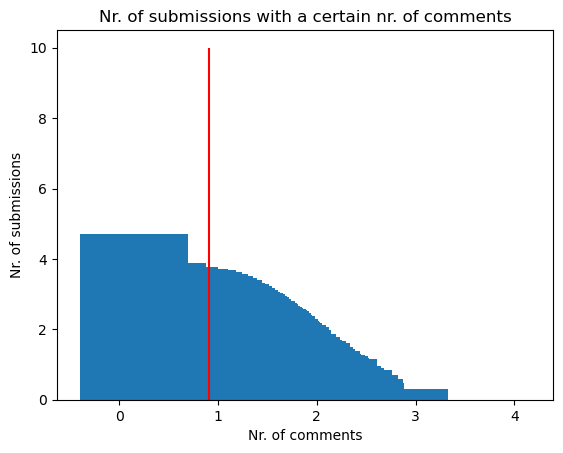

In [15]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['log_com_count'], height = plt_data['log_class_count'])
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=10)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

In [16]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 8.069921962358315
Nr. of submission, that I have comments for 169918
All submissions found
Removing empty submissions deleted 119842 submissions
Kept 50076 submissions
Nr. of comments, whose submission is retaied 1003587
Share 0.7318908275447137


In [17]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

# 189.000 submissions, 170.000 had comments, 120.000 were empty
# end up 50.000
# keep 1/4

Number of relevant submissions: 50076
Lost submissions:  138428


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.303010e+09,grsi7,2sfmf,"I'll let Lewis Black explain it to you. ""The D...",grsi7,c1pt5h6,c1pt5h6,8,8,0,PoliticalDiscussion,None,None,None,None,None,2011-04-17,comment
1,[deleted],1.303014e+09,grsi7,2sfmf,"Well, to be frank, it sounds like you are fair...",grsi7,c1ptgcy,c1ptgcy,6,6,0,PoliticalDiscussion,None,None,None,None,None,2011-04-17,comment
2,AustraLucy,1.303059e+09,grsi7,2sfmf,I think bipartisanship will be the end of Amer...,grsi7,c1pvl6a,c1pvl6a,1,1,0,PoliticalDiscussion,None,None,None,None,None,2011-04-17,comment
3,theiamina,1.303063e+09,grqj9,2sfmf,You claim to know your audience so well in you...,grqj9,c1pvucb,c1pvucb,0,0,0,PoliticalDiscussion,None,None,None,None,None,2011-04-17,comment
4,avd007,1.303068e+09,grqj9,2sfmf,I think you missed a core issue here. the prob...,grqj9,c1pw8hh,c1pw8hh,0,0,0,PoliticalDiscussion,None,None,None,None,None,2011-04-17,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003582,Tex-Rob,1.704065e+09,18tsmpm,2sfmf,Parties are terrible as a way to control outco...,18tsmpm,kfrj0ft,kfrj0ft,1,1,0,PoliticalDiscussion,None,,False,True,None,2024-01-01,comment
1003583,Madhatter25224,1.704065e+09,18uryo1,2sfmf,Lobbying is illegal. Anyone elected to any pub...,18uryo1,kfrkedm,kfrkedm,1,1,0,PoliticalDiscussion,None,,False,True,None,2024-01-01,comment
1003584,gaxxzz,1.704066e+09,18uou00,2sfmf,Russia has been threatening to use nuclear wea...,18uou00,kfrlee3,kfrlee3,1,1,0,PoliticalDiscussion,None,,False,True,None,2024-01-01,comment
1003585,ruminaui,1.704066e+09,18uyiyk,2sfmf,"Because we all know who the nominee is, and no...",18uyiyk,kfrll89,kfrll89,1,1,0,PoliticalDiscussion,None,,False,True,None,2024-01-01,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [18]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 886145
Nr. of unique comments 412785
Nr. of unique submissions 46199


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c1pt5h6,c1ptav6,Well that actually kind of helps a lot.,PoliticalDiscussion,1.303012e+09,snorky94,1,1,0,grsi7,...,[deleted],8,8,0,1.303010e+09,"Oops, I mean ""bipartisanship.""",snorky94,10.0,3,1.303003e+09
1,c1ptgcy,c1pto8a,"No, I am honestly open to any explanation of w...",PoliticalDiscussion,1.303017e+09,snorky94,2,2,0,grsi7,...,[deleted],6,6,0,1.303014e+09,"Oops, I mean ""bipartisanship.""",snorky94,10.0,3,1.303003e+09
2,c1pvucb,c1pwq17,Well thanks for having the patience to wade th...,PoliticalDiscussion,1.303074e+09,dtmike07,2,2,0,grqj9,...,theiamina,0,0,0,1.303063e+09,I've been an adherent of or flirted with most ...,dtmike07,15.0,7,1.302996e+09
3,c1pt5h6,c1pwryi,I think the reverse makes more sense.,PoliticalDiscussion,1.303075e+09,[deleted],1,1,0,grsi7,...,[deleted],8,8,0,1.303010e+09,"Oops, I mean ""bipartisanship.""",snorky94,10.0,3,1.303003e+09
4,c1pw8hh,c1pwsh4,Very good point - I felt bad using the labels ...,PoliticalDiscussion,1.303075e+09,dtmike07,0,0,0,grqj9,...,avd007,0,0,0,1.303068e+09,I've been an adherent of or flirted with most ...,dtmike07,15.0,7,1.302996e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886144,kfqdbma,kfrien2,I meant the legislature members from a given p...,PoliticalDiscussion,1.704064e+09,Awesomeuser90,2,2,0,18vas2y,...,Sands43,16,16,0,1.704049e+09,America is reputed for their legislature with ...,Awesomeuser90,16.0,16,1.704039e+09
886145,kfpr5h6,kfrj1xb,I was more so alluding to the reputation of th...,PoliticalDiscussion,1.704065e+09,Awesomeuser90,2,2,0,18vas2y,...,CorporateNonperson,18,18,0,1.704041e+09,America is reputed for their legislature with ...,Awesomeuser90,16.0,16,1.704039e+09
886146,kfn0ce4,kfrl1pz,>Putin has been *threatening* to use them for ...,PoliticalDiscussion,1.704066e+09,gaxxzz,1,1,0,18uou00,...,BitterFuture,120,120,0,1.703987e+09,Much has been made about Putin using a nuke to...,Mad_Prog_1,35.0,35,1.703968e+09
886147,kfoiclq,kfrlbx9,She wasn’t even the best black woman for the j...,PoliticalDiscussion,1.704066e+09,kimanf,1,1,0,18u0jvx,...,SeekSeekScan,2,2,0,1.704016e+09,This assumes that in the next couple of months...,DenseYear2713,2.0,2,1.703892e+09


In [19]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [20]:
df_matched['body_child'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
[removed]                                                                          33432
[deleted]                                                                          30734
Why?                                                                                 206
Do not submit low investment content. This subreddit is for genuine discussion.      152
Source?                                                                              123
Name: count, dtype: int64

In [21]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 102948 interactions. Share:  0.11617459366314242
Kept 783201 interactions.
Deleting empty authors deleted 75737 interactions. Share:  0.09670186835818646
Kept 707464 interactions.
Length 5 removes 38371 interactions
Kept 669093 interactions
Drop duplicates (in parent & child text and author) removed 6 interactions. Share:  8.967363281337572e-06
Kept 669087 interactions.
After text cleaning 954 interactions had empty texts and got removed. Share:  0.0014258235476104005
Kept 668133 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c1pvucb,c1pwq17,Well thanks for having the patience to wade th...,PoliticalDiscussion,1.303074e+09,dtmike07,2,2,0,grqj9,...,theiamina,0,0,0,1.303063e+09,I've been an adherent of or flirted with most ...,dtmike07,15.0,7,1.302996e+09
1,c1pw8hh,c1pwsh4,Very good point - I felt bad using the labels ...,PoliticalDiscussion,1.303075e+09,dtmike07,0,0,0,grqj9,...,avd007,0,0,0,1.303068e+09,I've been an adherent of or flirted with most ...,dtmike07,15.0,7,1.302996e+09
2,c1pwkxk,c1pyoun,Well that was insightful. Thanks Reminds me of...,PoliticalDiscussion,1.303098e+09,snorky94,0,0,0,grsi7,...,ReferentiallySeethru,2,2,0,1.303072e+09,"Oops, I mean bipartisanship.",snorky94,10.0,3,1.303003e+09
3,c1rzgqn,c1rzi35,Karma Circlejerks of this magnitude are few an...,PoliticalDiscussion,1.304315e+09,funkinthetrunk,5,5,0,h1vss,...,daychilde,3,3,0,1.304315e+09,Does it make Obama look tough on terror? Will ...,funkinthetrunk,11.0,10,1.304308e+09
4,c1s5jhd,c1s5lgd,I didn't know there was a withdrawal scheduled...,PoliticalDiscussion,1.304397e+09,funkinthetrunk,1,1,0,h1vss,...,ACHILLESiii,2,2,0,1.304396e+09,Does it make Obama look tough on terror? Will ...,funkinthetrunk,11.0,10,1.304308e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668128,kfqdbma,kfrien2,I meant the legislature members from a given p...,PoliticalDiscussion,1.704064e+09,Awesomeuser90,2,2,0,18vas2y,...,Sands43,16,16,0,1.704049e+09,America is reputed for their legislature with ...,Awesomeuser90,16.0,16,1.704039e+09
668129,kfpr5h6,kfrj1xb,I was more so alluding to the reputation of th...,PoliticalDiscussion,1.704065e+09,Awesomeuser90,2,2,0,18vas2y,...,CorporateNonperson,18,18,0,1.704041e+09,America is reputed for their legislature with ...,Awesomeuser90,16.0,16,1.704039e+09
668130,kfn0ce4,kfrl1pz,Putin has been threatening to use them for ove...,PoliticalDiscussion,1.704066e+09,gaxxzz,1,1,0,18uou00,...,BitterFuture,120,120,0,1.703987e+09,Much has been made about Putin using a nuke to...,Mad_Prog_1,35.0,35,1.703968e+09
668131,kfoiclq,kfrlbx9,She wasnt even the best black woman for the jo...,PoliticalDiscussion,1.704066e+09,kimanf,1,1,0,18u0jvx,...,SeekSeekScan,2,2,0,1.704016e+09,This assumes that in the next couple of months...,DenseYear2713,2.0,2,1.703892e+09


In [22]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


## **Check for Mods**

In [36]:
df['author_submission'].value_counts()[:20]

author_submission
Anxa                    57324
Miskellaneousness       21688
BagOnuts                21388
The_Egalitarian         11757
Precursor2552           11163
dubalubdub               9586
PsychLegalMind           8172
amici_ursi               4517
premeddit                3925
hearsdemons              3171
TaylorSwiftian           2559
garfangle                2392
sgwashere29              2223
Redleg61                 2023
strongerthenbefore20     1650
Topher1999               1626
KeyzerSozee              1596
kingvitaman              1594
CrapNeck5000             1583
MrIvysaur                1562
Name: count, dtype: int64

In [37]:
df['author_parent'].value_counts()[:20]

author_parent
looklistencreate      2507
houinator             2227
ClockOfTheLongNow     2227
cassander             1764
lollersauce914        1663
mrhymer               1470
thatnameagain         1333
Valanarch             1325
DevonWeeks            1307
BagOnuts              1299
repmack               1273
intravenus_de_milo    1150
Miskellaneousness     1127
prizepig              1121
Quetzalcoatls         1081
GTFErinyes            1049
fatcIemenza            966
down42roads            926
narutouz               917
teddilicious           881
Name: count, dtype: int64

In [38]:
df['author_child'].value_counts()[:20]

author_child
ClockOfTheLongNow       1562
bl1y                    1438
PsychLegalMind          1419
AgoraiosBum             1333
Valanarch               1298
cassander               1141
evanb_                  1136
BitterFuture            1099
imrightandyoutknowit    1006
Mist_Rising              999
thatnameagain            961
looklistencreate         953
Chernograd               947
bartink                  904
ballmermurland           903
Miskellaneousness        852
mdude04                  838
Santoron                 787
anneoftheisland          783
DeHominisDignitate       764
Name: count, dtype: int64

In [ ]:

# print("Child", len(df[df['author_child'] == 'AutoModerator']))
# print("Parent", len(df[df['author_parent'] == 'AutoModerator']))
# print("Submission", len(df[df['author_submission'] == 'AutoModerator']))

# len(df)

Child 567
Parent 4
Submission 31


9312

In [ ]:
# df[df['author_child'] == "AutoModerator"]['body_child'].value_counts()

body_child
Your comment was removed because you do not have a user flair. We require members to have a user flair to participate on this sub. For instructions on how to add a user flair click here I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.                                                                                                                         545
Your comment was removed for being uncivilized, which breaks our rules. We encourage you to repost your comment in a more civilized manner. I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.                                                                                                                                                                        16
Your post has been removed due to the use of mu

In [ ]:
# df[df['author_parent'] == 'AutoModerator']['body_parent'].value_counts()

body_parent
 Reminder that this sub is for civilized discussion. No name calling or insults will be tolerated. If you're a new member you need a user flair to participate, so flair up! I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.    3
Reminder that this sub is for civilized discussion. No name calling or insults will be tolerated. If you're a new member you need a user flair to participate, so flair up! I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.     1
Name: count, dtype: int64

In [ ]:
# df[df['author_submission'] == 'AutoModerator']['submission_text'].value_counts()

submission_text
This thread serves as a way to ease off the stress and anger that goes along with these political debates. Talk about anything and everything. Book clubs, TV, current events, sports, personal lives, study groups, etc. Our rules are still enforced, remain civilized. Also I'm once again asking you to report any uncivilized behavior. Help us mods keep the subs standard of discourse high and don't let anything slip between the cracks.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# df_no_mod = df[df['author_child'] != 'AutoModerator'].reset_index(drop = True)
# df_no_mod = df_no_mod[df_no_mod['author_parent'] != 'AutoModerator'].reset_index(drop = True)
# #df_no_mod = df_no_mod[df_no_mod['author_submission'] != 'AutoModerator'].reset_index(drop = True)

# print(len(df) - len(df_no_mod))

# df_no_mod

571


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6jvc,Should have taken the blue pill.\r \r FTFY,PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
3,c0d5zrm,c0d7f4g,I backed up Glenn Beck as long as I could but ...,PoliticalDebate,1.253072e+09,orblivion,1.0,1,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
4,c7fp9wr,c7fpb3l,I seem to notice that as well. It said the nam...,PoliticalDebate,1.355362e+09,ChurroMooCow,1.0,1,0.0,14r5kt,...,Trayf,2.0,2,0.0,1.355362e+09,Hi guys! I would like to proudly announce that...,ChurroMooCow,2.0,2,1.355356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8736,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,1.704058e+09,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,1.703983e+09,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,1.703967e+09
8737,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,1.704061e+09,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,1.704000e+09,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,1.703970e+09
8738,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09
8739,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09


### Save and export

In [30]:
# to csv
zip_filename = f"output/{subreddit_here}_new_preprocessing_com_rep.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
    with zf.open(output_path, 'w') as f:
        df.to_csv(f, index=False)


# import again
with zipfile.ZipFile(zip_filename, 'r') as zf:
    with zf.open(output_path) as f:
        df = pd.read_csv(f)

df

df.to_csv(output_path, index = False)

***
## **Descriptive Stats**

In [31]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

273272
Unique Users:  240187


### Time Stats and originally pulled counts

In [32]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2011-04-15
End of time frame: 2024-01-01
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 188504
Number of comments and replies: 6839338
---------------------------------------------



### Descriptive Stats after Matching

In [33]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  886145
Number of unique comments:  412785
Number of unique submissions:  46199


### Descriptive Stats after cleaning for high quality texts

In [34]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  668133
Unique Comments:  324723
Unique Submissions:  39239


In [35]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  105037
